# Análisis de las señales usando inferencia bayesiana

In [537]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
sns.set()
import pandas as pd
import pickle

import theano.tensor as TT
import time
import random

import pymc3 as pm
import arviz as az

import sys
#import winsound

%run Bayes2.ipynb

In [538]:
PATH = sys.path[0]
print(PATH)

/home/gordotony/Documents/GitHub/tesis/Bayesiano/Ajustes


In [539]:
portadora = input('Fc7 , Fc8')
mediciones = ['05_27','06_09','07_15','08_22']
X = input('medicion calibracion (may=0, jun=1, jul=2, ag=3, S1_avg=A)')
Y = input('medicion target (may=0, jun=1, jul=2, ag=3)')
altura = input('altura :0, 1, 2 o 3')

if X == 'A':
    dia_cal = 'S1_av'
else:
    dia_cal = mediciones[int(X)]
    
dia_tar = mediciones[int(Y)]    

In [540]:
## Parámetros globales de la antena

Fs = 23.328e9 #Frecuencia de muestreo [Hz] 
Ts = 1/Fs
BW = 1.5e9 

corte = 150
Nfft= 1024 # nro de frecs -> conviene que sea multiplo de 2 para calcular la FFT de manera eficiente. 
#Tiene que ser mayor a la longitud de la señal (285 para 2m, 439 para 3m)

if portadora== 'Fc7':
    fc = 7.290e9
    print('fc =',str(fc/1e9) + 'GHz')
elif portadora== 'Fc8':
    fc = 8.748e9
    print('fc =',str(fc/1e9) + 'GHz')
else:
    print('Error: portadora debe ser Fc7 o Fc8')

fc = 8.748GHz


## Cargo las mediciones

In [541]:
if portadora == 'Fc8':
    # Frecuencias positivas obtenidas de la FFT
    f_pos = np.load('mediciones/f.npy',mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
    
    with open('mediciones/altura_'+altura+'.pkl','rb') as Q:
        med = pickle.load(Q)
    print(med.keys())
    Star = med.get('S2_'+dia_tar)

    if X == 'A':
        with open('mediciones/'+dia_cal+'.pkl','rb') as T:
            S1_av = pickle.load(T)
        print(S1_av.keys()) 
        Scal = S1_av.get('S1_av')
        Scal = Scal[int(altura)] 
    else:
        Scal = med.get('S1_'+dia_cal)
        
else:
    print('las mediciones para Fc7 no estan procesadas')

print('dim fpos:',np.shape(f_pos))
print('dim S1:',np.shape(Scal))
print('dim S2:',np.shape(Star)) 

dict_keys(['S1_05_27', 'S2_05_27', 'S1_06_09', 'S2_06_09', 'S1_07_15', 'S2_07_15', 'S1_08_22', 'S1B_08_22', 'S2_08_22'])
dim fpos: (153,)
dim S1: (153,)
dim S2: (153,)


In [542]:
## Mediciones con el hydra
if Y == '0':
    # mayo
    ep1_obs = (20.731 + 1j*8.688) - 1j #2cm
    ep2_obs = (23.299 + 1j*9.799) - 1j #6,5cm
    ep3_obs = (25.813+10.474j) - 1j #12cm 
    
elif Y == '1':
    # junio
    ep1_obs = (11.496 +1j*4.028) - 1j #2,5cm
    ep2_obs = (13.894 + 1j*5.12) - 1j #7cm
    ep3_obs = (22.823 + 1j*18.73) - 1j #13cm

elif Y == '2':
    # julio
    ep1_obs = (8.129 +1j*4.91) -1j #2cm
    ep2_obs = (10.302 + 1j*6.12) -1j #7cm
    ep3_obs = (11.268 + 1j*6.695) -1j#14cm

else:
    # agosto
    ep1_obs = 7.6 + 1j*4.36 #2cm
    ep2_obs = 7.54 + 1j*3.94 #9cm
    ep3_obs = 'error' #no se medio otra humedad


In [543]:
# ## hago un ajuste rápido con el modelo de Pinel para ver si tiene buena pinta

# %run Pinel.ipynb
# # R_pinel_2L(ep1,ep2,d1,s0,s1,f)
# #R_pinel_3L(ep1,ep2,ep3,d1,d2,s0,s1,s2,f,n_layers):

# d1 = 0.065
# d2 = 0.12
# s0 = 1e-3
# s1 = 1.5e-4
# s2 = 0.5e-4

# ajuste_2L = np.abs(Scal*R_pinel_2L(ep1_obs,ep2_obs,d1,s0,s1,f_pos))
# ajuste_3L = np.abs(Scal*R_pinel_3L(ep1_obs,ep2_obs,ep3_obs,d1,d2,s0,s1,s2,f_pos))
# X2 = np.abs(Star)

# plt.figure(figsize=(12,8))
# plt.plot(f_pos/1e9,ajuste_2L,label="Ajuste - 2 capas")
# plt.plot(f_pos/1e9,ajuste_3L,label="Ajuste - 3 capas")
# plt.plot(f_pos/1e9,X2,label="Target")
# plt.legend(loc = "best")
# plt.show()

# Ajustes con el esquema bayesiano:
 - sin rugosidad ---> busco $\{ \epsilon_\,,\,d_n \}$ óptimos en el coeficiente de Fresnel
 - con rugosidad ---> busco $\{ \epsilon_\,,\,d_n, h_n \}$ óptimos en el modelo de Pinel

## - Un solo dieléctrico (no considero capas)

Dieléctrico: $\epsilon = \epsilon_r -\imath\,\epsilon_i$

*Skin Depth ($\delta_D$):*

low-loss medium:
$\delta_D = \frac{\lambda}{2\,c}\sqrt{\frac{\epsilon_r}{\epsilon^2_i}}$

Delta de Marian:
$\delta_D = \frac{2\epsilon_r 2x10^8}{2\pi f \epsilon_i}$

-------------------
Incidencia en un dielectrico sin rugosidad
-------------------

Datos:
Dia de calibracion: 07_15
Dia de target: 08_22
Altura: 1

long. onda portadora: 3.43cm
Skin Depth a Fc8) : 1.27cm

long. onda max: 4.14cm
Skin Depth a long. onda max: 1.53cm


-------------------
Corro bayes
-------------------
Ruido :  0.0225
Muestras :  5000



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.013
Stage:   2 Beta: 0.028
Stage:   3 Beta: 0.060
Stage:   4 Beta: 0.133
Stage:   5 Beta: 0.295
Stage:   6 Beta: 0.648
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.013
Stage:   2 Beta: 0.028
Stage:   3 Beta: 0.061
Stage:   4 Beta: 0.134
Stage:   5 Beta: 0.293
Stage:   6 Beta: 0.646
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.013
Stage:   2 Beta: 0.028
Stage:   3 Beta: 0.061
Stage:   4 Beta: 0.133
Stage:   5 Beta: 0.294
Stage:   6 Beta: 0.645
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.013
Stage:   2 Beta: 0.028
Stage:   3 Beta: 0.061
Stage:   4 Beta: 0.134
Stage:   5 Beta: 0.296
Stage:   6 Beta: 0.650
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.013
Stage:   2 Beta: 0.028
Stage:   3 Beta: 0.060
Stage:   4 Beta: 0.134
Stage:   5 Beta: 0.294
Stage:   6 Beta: 0.645
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.006
S

Tiempo insumido - Inf. Bayesiana: 52.5 seg (0.87 min)
Graficando con un solo dielectrico ...

input ep1_r:  7.6
output ep1_r:  4.044 +/- 0.041

input ep1_i:  4.36
output ep1_i:  3.022 +/- 0.021

Tiempo insumido - Graficos: 1.61 seg (0.03 min)

Tiempo insumido - TOTAL: 54.11 seg (0.9 min)





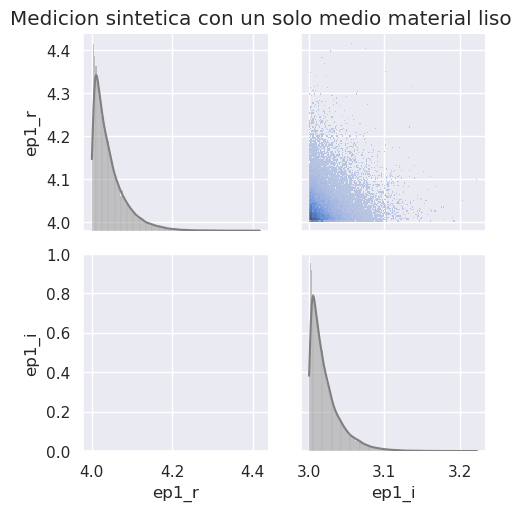

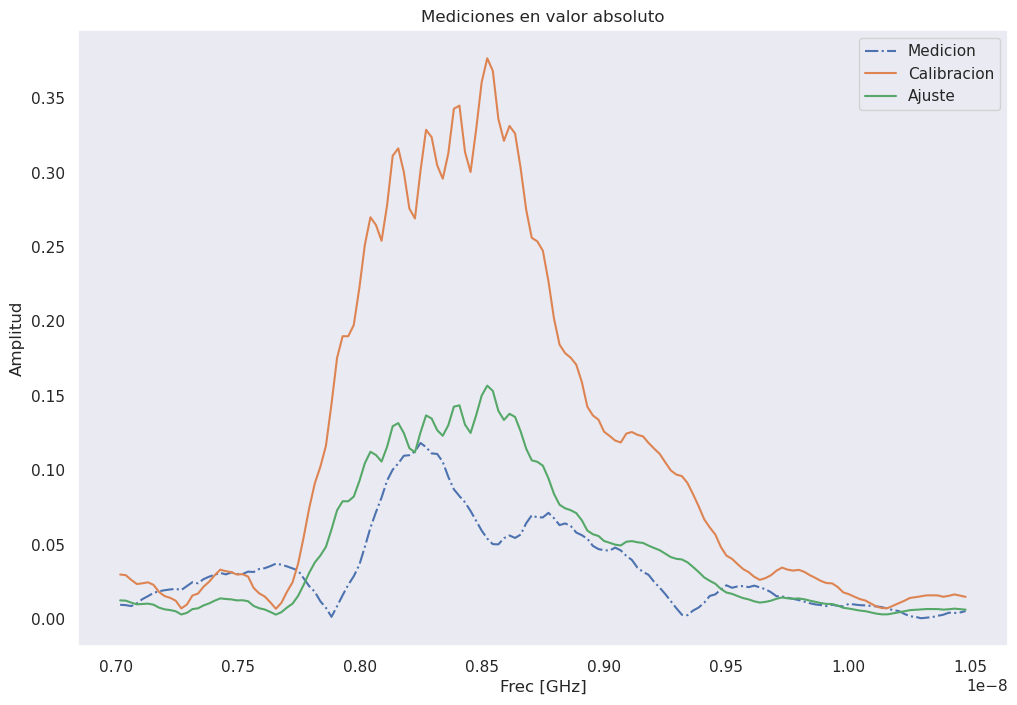

In [544]:
# %%capture cap --no-stderr
NLayers = 1
print('-------------------')
print('Incidencia en un dielectrico sin rugosidad')
print('-------------------')
print()
print('Datos:')
print('Dia de calibracion:', dia_cal)
print('Dia de target:', dia_tar)
print('Altura:', altura)
name = 'lisa-C'+X+'-T'+Y+'-A'+altura
print()


##long de onda
landa = 3e8/fc
print('long. onda portadora:',str(round(100*landa,2))+'cm')

## skin depth para la portadora con ep1 medido
delta_d = 2*np.real(ep1_obs)*2e8/(2*np.pi*(fc)*np.imag(ep1_obs)) #PREGUNTAR A MARIANO DE DONDE SACO ESA SKIN DEPTH
print('Skin Depth a '+portadora+') :',str(round(100*delta_d,2))+'cm')
print()

landa_max = 3e8/(fc-BW)
print('long. onda max:',str(round(100*landa_max,2))+'cm')
delta_max = 2*np.real(ep1_obs)*2e8/(2*np.pi*(fc-BW)*np.imag(ep1_obs))
print('Skin Depth a long. onda max:', str(round(100*delta_max,2))+'cm')
print()
print()


print('-------------------')
print('Corro bayes')
print('-------------------')

t0 = time.time()
# nro de muestras que va a utilizar el método
noise_level = 2.25e-2
print('Ruido : ',noise_level)
muestras = 5000
print('Muestras : ',muestras)
# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))
print()


# inferencia bayesiana
traza_sim_1layer = modelo(Star,muestras,sigmas,NLayers,False)
t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')


t2 = time.time()
print('Graficando con un solo dielectrico ...')

ep1_r_mean = round(np.mean(traza_sim_1layer['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_1layer['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_1layer['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_1layer['ep1_i']),3)

plotear = np.stack((traza_sim_1layer['ep1_r'], traza_sim_1layer['ep1_i'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r', 'ep1_i'])


g = sns.PairGrid(dfplotear)
g.fig.suptitle('Medicion sintetica con un solo medio material liso', y=1.01, fontsize = 'large')
g.map_upper(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
# g.axes[0,0].axvline(np.real(ep1_obs), color='r', linestyle='solid', linewidth=0.5)
# g.axes[1,0].scatter(np.real(ep1_obs), np.imag(ep1_obs), marker="+", c='r', s=200)
# g.axes[1,1].axvline(np.imag(ep1_obs), color='r', linestyle='solid', linewidth=0.5)
g.savefig('outputs/1capa/bayes-'+name+'.png')

print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
print()
print('input ep1_i: ', round(np.imag(ep1_obs),3))
print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
print()

t3 = time.time()
print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()

#-----------------------------
EP1 = ep1_r_mean + 1j*ep1_i_mean
S_fit = Scal*R_ep(EP1)

plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.title('Mediciones en valor absoluto')
plt.legend(loc="best")
plt.savefig('outputs/1capa/fig-'+name+'.png')

#----------------------------------

with open('outputs/1capa/'+name+'.txt', 'w') as f:
    print('-------------------', file=f)
    print('Incidencia en un dielectrico sin rugosidad', file=f)
    print('-------------------', file=f)
    print('', file=f)
    print('Datos:', file=f)
    print('Dia de calibracion:', dia_cal, file=f)
    print('Dia de target:', dia_tar, file=f)
    print('Altura:', altura, file=f)
    print('', file=f)
    print('long. onda portadora:',str(round(100*landa,2))+'cm', file=f)
    print('long. onda max:',str(round(100*landa_max,2))+'cm', file=f)
    print('Skin Depth a '+portadora+') :',str(round(100*delta_d,2))+'cm', file=f)
    print('Skin Depth a long. onda max:', str(round(100*delta_max,2))+'cm', file=f)
    print('', file=f)
    print('', file=f)
    print('-------------------', file=f)
    print('Corro bayes', file=f)
    print('-------------------', file=f)
    print('Ruido : ',noise_level, file=f)
    print('Muestras : ',muestras, file=f)
    print('', file=f)
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('Graficando con un solo dielectrico ...', file=f)
    print('input ep1_r: ', np.real(ep1_obs), file=f)
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
    print('', file=f)
    print('input ep1_i: ', round(np.imag(ep1_obs),3), file=f)
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
    print('', file=f)
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('', file=f)
f.close()

#winsound.PlaySound("SystemExit", winsound.SND_ALIAS)


# - Dos dieléctricos

In [545]:
NLayers = 2
if Y == '0':
    # mayo
    d_obs = 0.12
    
    
elif Y == '1':
    # junio
    d_obs = 0.13
    

elif Y == '2':
    # julio
    d_obs = 0.14

else:
    # agosto
    d_obs = 0.09
    

## Sin rugosidad

-------------------
Incidencia en un dielectrico con 2 capas sin rugosidad
-------------------

Datos:
Dia de calibracion: 07_15
Dia de target: 08_22
Altura: 1

-------------------
Corro bayes
-------------------
Ruido :  0.0225
Muestras :  5000



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
/home/gordotony/anaconda3/envs/UWB/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.012
Stage:   1 Beta: 0.037
Stage:   2 Beta: 0.115
Stage:   3 Beta: 0.378
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.012
Stage:   1 Beta: 0.036
Stage:   2 Beta: 0.112
Stage:   3 Beta: 0.368
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.012
Stage:   1 Beta: 0.037
Stage:   2 Beta: 0.116
Stage:   3 Beta: 0.376
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.012
Stage:   1 Beta: 0.037
Stage:   2 Beta: 0.113
Stage:   3 Beta: 0.374
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.012
Stage:   1 Beta: 0.037
Stage:   2 Beta: 0.113
Stage:   3 Beta: 0.371
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.012
Stage:   1 Beta: 0.036
Stage:   2 Beta: 0.112
Stage:   3 Beta: 0.369
Stage:

Tiempo insumido - Inf. Bayesiana: 94.45 seg (1.57 min)
Graficando para 2 layers ...


input ep1_r:  7.6
output ep1_r:  9.094 +/- 2.7

input ep1_i:  4.36
output ep1_i:  5.991 +/- 1.153

input ep2_r:  7.54
output ep2_r:  13.546 +/- 0.044

input ep2_i:  3.94
output ep2_i:  8.498 +/- 1.447

input d:  0.09
output d:  0.005 +/- 0.003

Tiempo insumido - Graficos: 4.29 seg (0.07 min)

Tiempo insumido - TOTAL: 98.74 seg (1.65 min)





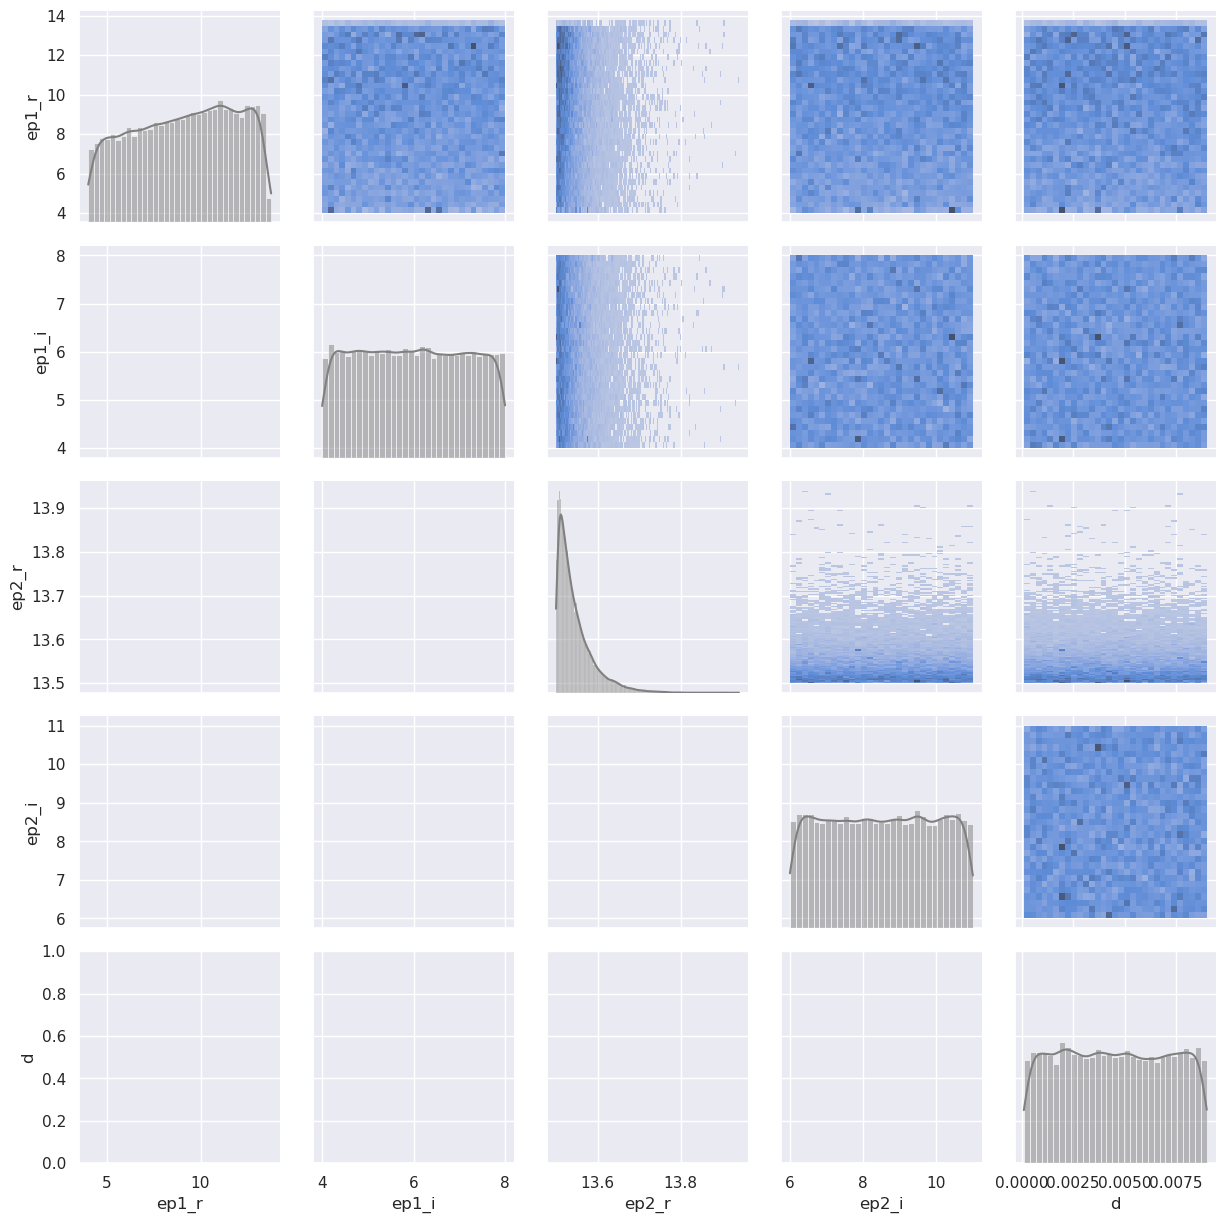

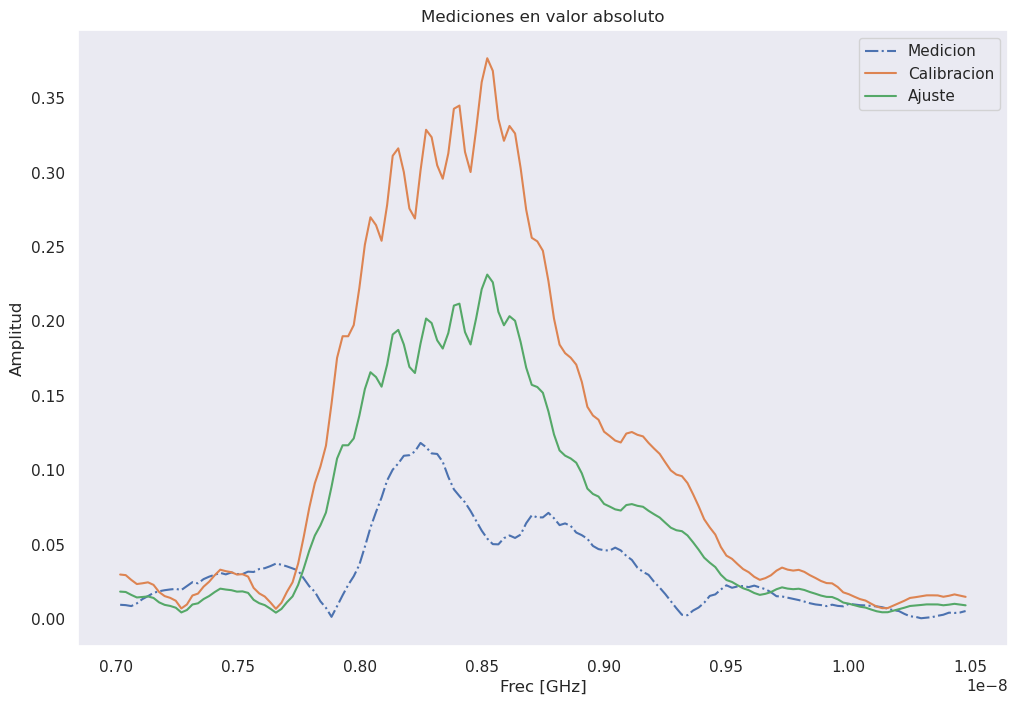

In [546]:
print('-------------------')
print('Incidencia en un dielectrico con 2 capas sin rugosidad')
print('-------------------')
print()
print('Datos:')
print('Dia de calibracion:', dia_cal)
print('Dia de target:', dia_tar)
print('Altura:', altura)
name = 'lisa-C'+X+'-T'+Y+'-A'+altura
print()
t0 = time.time()


print('-------------------')
print('Corro bayes')
print('-------------------')
# nro de muestras que va a utilizar el método
muestras = 5000
noise_level = 2.25e-2
# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))

print('Ruido : ',noise_level)
print('Muestras : ',muestras)
print()

# inferencia bayesiana
traza_sim_2layers = modelo(Star,muestras,sigmas,NLayers,rug=False)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

#Ploteo
t2 = time.time()
print('Graficando para 2 layers ...')
print()

ep1_r_mean = round(np.mean(traza_sim_2layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_2layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_2layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_2layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_2layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_2layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_2layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_2layers['ep2_i']),3)

d_mean = round(np.mean(traza_sim_2layers['d']),3)
d_std = round(np.std(traza_sim_2layers['d']),3)


plotear = np.stack((traza_sim_2layers['ep1_r'], traza_sim_2layers['ep1_i'], traza_sim_2layers['ep2_r'], 
                    traza_sim_2layers['ep2_i'], traza_sim_2layers['d'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep1_i','ep2_r','ep2_i','d'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
#g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
g.savefig('outputs/2capas/bayes-'+name+'.png')

# g.axes[0,0].axvline(np.real(ep1_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[1,1].axvline(np.imag(ep1_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[2,2].axvline(np.real(ep2_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[3,3].axvline(np.imag(ep2_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[4,4].axvline(d_s, color='r', linestyle='solid', linewidth=0.5)

# g.axes[1,0].scatter(np.real(ep1_s), np.imag(ep1_s), marker="+", c='r', s=200)
# g.axes[2,0].scatter(np.real(ep1_s), np.real(ep2_s), marker="+", c='r', s=200)
# g.axes[3,0].scatter(np.real(ep1_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,0].scatter(np.real(ep1_s), d_s, marker="+", c='r', s=200)

# g.axes[2,1].scatter(np.imag(ep1_s), np.real(ep2_s), marker="+", c='r', s=200)
# g.axes[3,1].scatter(np.imag(ep1_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,1].scatter(np.imag(ep1_s), d_s, marker="+", c='r', s=200)

# g.axes[3,2].scatter(np.real(ep2_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,2].scatter(np.real(ep2_s), d_s, marker="+", c='r', s=200)

# g.axes[4,3].scatter(np.imag(ep2_s), d_s, marker="+", c='r', s=200)


print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std))
print()
print('input d: ', d_obs)
print('output d: ', str(d_mean)+" +/- "+str(d_std))
print()

t3 = time.time()
print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()

#---------------------------------------------
EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
Dis = d_mean

S_fit = Scal*R_ep1_ep2(EP1,EP2,Dis,f_pos)

plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.title('Mediciones en valor absoluto')
plt.legend(loc="best")
plt.savefig('outputs/2capas/fig-'+name+'.png')
#----------------------------------------------

with open('outputs/2capas/'+name+'.txt', 'w') as f:
    print('-------------------', file=f)
    print('Incidencia en un dielectrico con 2 capas sin rugosidad', file=f)
    print('-------------------', file=f)
    print('', file=f)
    print('Datos:', file=f)
    print('Dia de calibracion:', dia_cal, file=f)
    print('Dia de target:', dia_tar, file=f)
    print('Altura:', altura, file=f)
    print('', file=f)
    print('', file=f)

    print('-------------------', file=f)
    print('Corro bayes', file=f)
    print('-------------------', file=f)
    print('Ruido : ',noise_level, file=f)
    print('Muestras : ',muestras, file=f)
    print('', file=f)
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
    print('', file=f)

    print('Graficando con un solo dielectrico ...', file=f)
    print('input ep1_r: ', np.real(ep1_obs), file=f)
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
    print('', file=f)
    print('input ep1_i: ', round(np.imag(ep1_obs)),3, file=f)
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
    print('', file=f)
    print('input ep2_r: ', np.real(ep2_obs), file=f)
    print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std), file=f)
    print('', file=f)
    print('input ep2_i: ', np.imag(ep2_obs), file=f)
    print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std), file=f)
    print('', file=f)
    print('input d: ', d_obs, file=f)
    print('output d: ', str(d_mean)+" +/- "+str(d_std), file=f)
    print('', file=f)
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('', file=f)
f.close()
#winsound.PlaySound("SystemExit", winsound.SND_ALIAS)

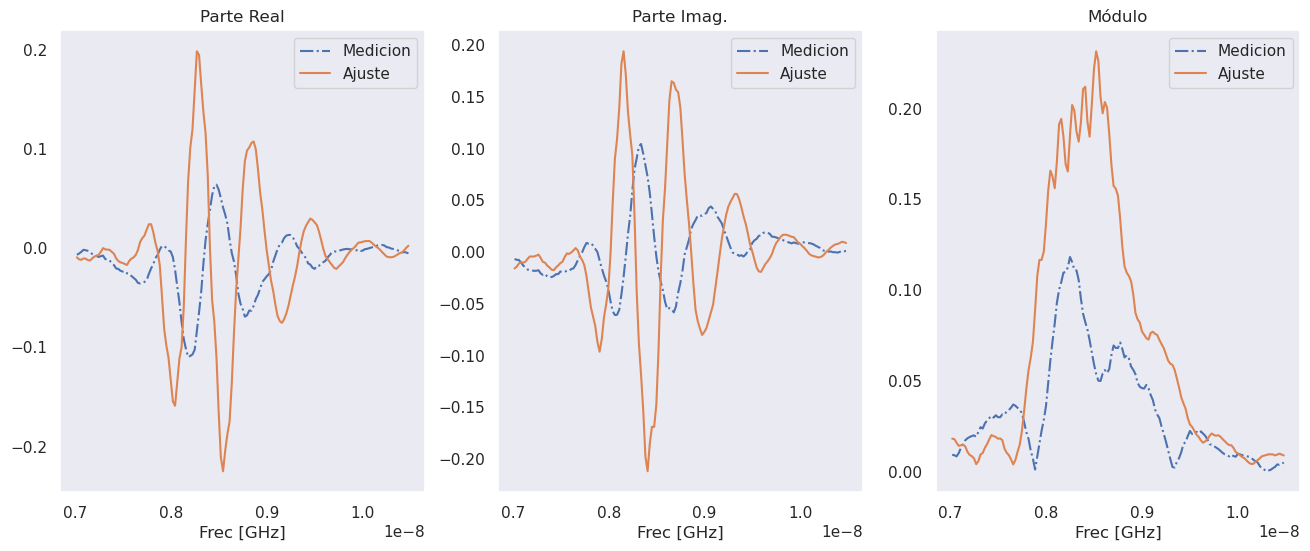

In [547]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(f_pos/1e9,np.real(Star),'-.',label="Medicion")
ax[0].plot(f_pos/1e9,np.real(S_fit),label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(f_pos/1e9,np.imag(Star),'-.',label="Medicion")
ax[1].plot(f_pos/1e9,np.imag(S_fit),label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
ax[2].plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()

## Con rugosidad

-------------------
Incidencia en un dielectrico con 2 capas con rugosidad
-------------------

Datos:
Dia de calibracion: 07_15
Dia de target: 08_22
Altura: 1

-------------------
Corro bayes
-------------------
Ruido :  0.025
Muestras :  5000



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
/home/gordotony/anaconda3/envs/UWB/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.021
Stage:   2 Beta: 0.059
Stage:   3 Beta: 0.159
Stage:   4 Beta: 0.408
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.021
Stage:   2 Beta: 0.060
Stage:   3 Beta: 0.160
Stage:   4 Beta: 0.417
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.020
Stage:   2 Beta: 0.059
Stage:   3 Beta: 0.159
Stage:   4 Beta: 0.399
Stage:   5 Beta: 0.993
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.021
Stage:   2 Beta: 0.060
Stage:   3 Beta: 0.166
Stage:   4 Beta: 0.429
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.020
Stage:   2 Beta: 0.060
Stage:   3 Beta: 0.162
Stage:

Tiempo insumido - Inf. Bayesiana: 146.95 seg (2.45 min)
Graficando para dos dieléctricos + rugosidad (esto puede demorar...)


input ep1_r:  7.6
output ep1_r:  17.529 +/- 0.987

input ep1_i:  4.36
output ep1_i:  3.987 +/- 1.151

input ep2_r:  7.54
output ep2_r:  18.821 +/- 0.064

input ep2_i:  3.94
output ep2_i:  5.491 +/- 1.437

input d:  0.09
output d:  0.055 +/- 0.026

input s1: ---
output s1:  0.00134 +/- 0.000468

input s2: ---
output s2:  0.00068 +/- 0.000466

Tiempo insumido - Graficos: 161.96 seg (2.7 min)

Tiempo insumido - TOTAL: 154.7 seg (2.58 min)





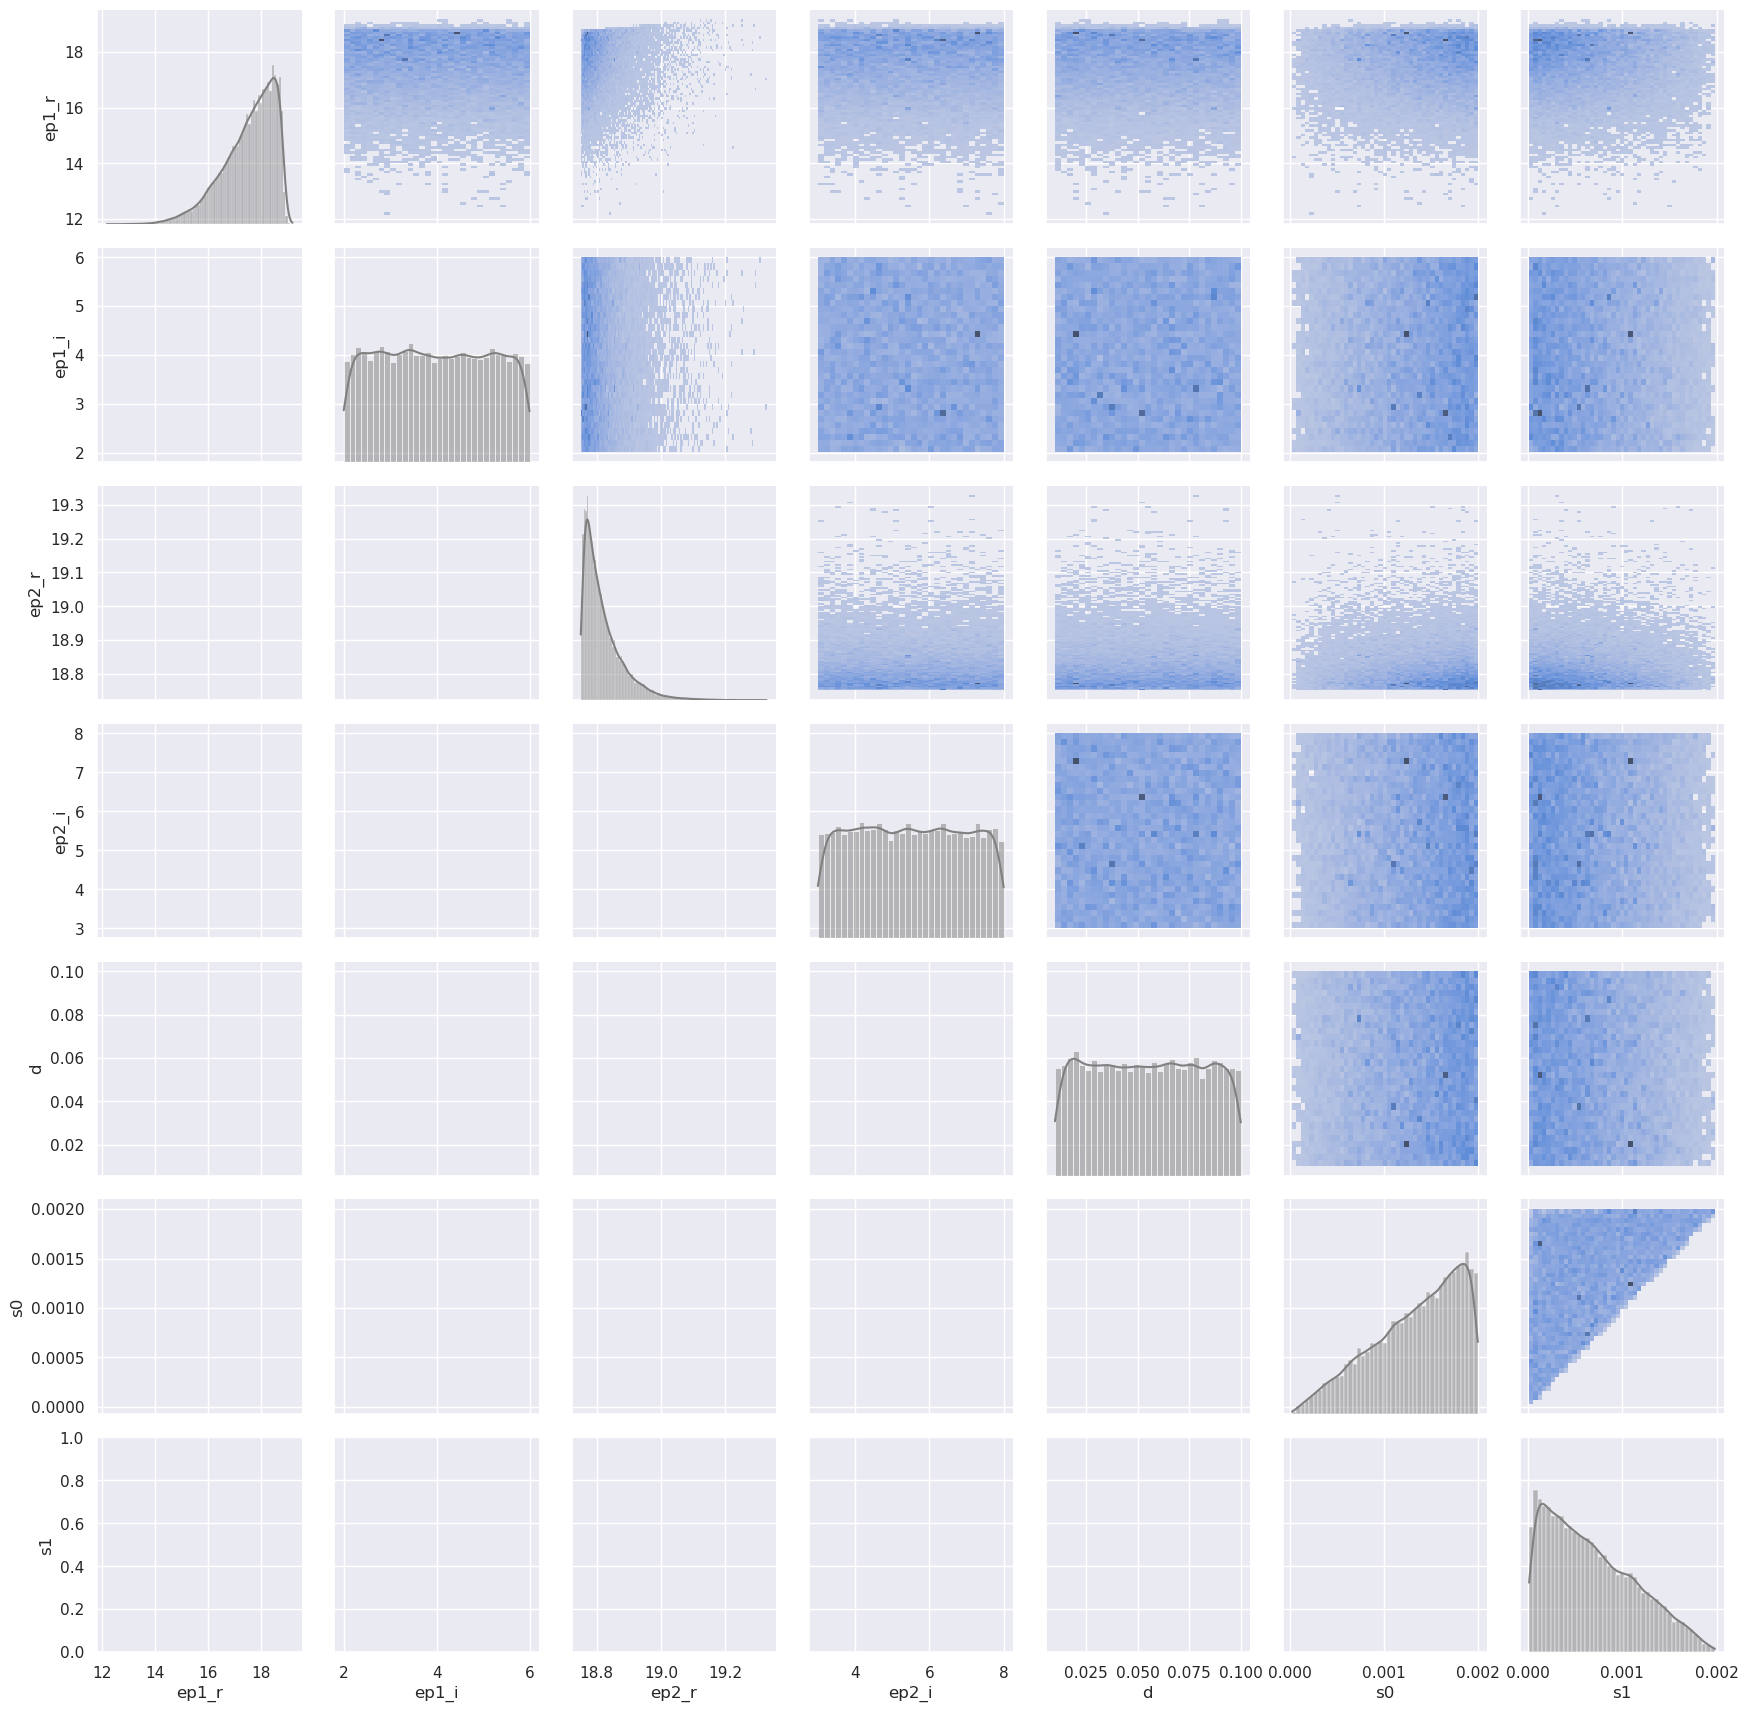

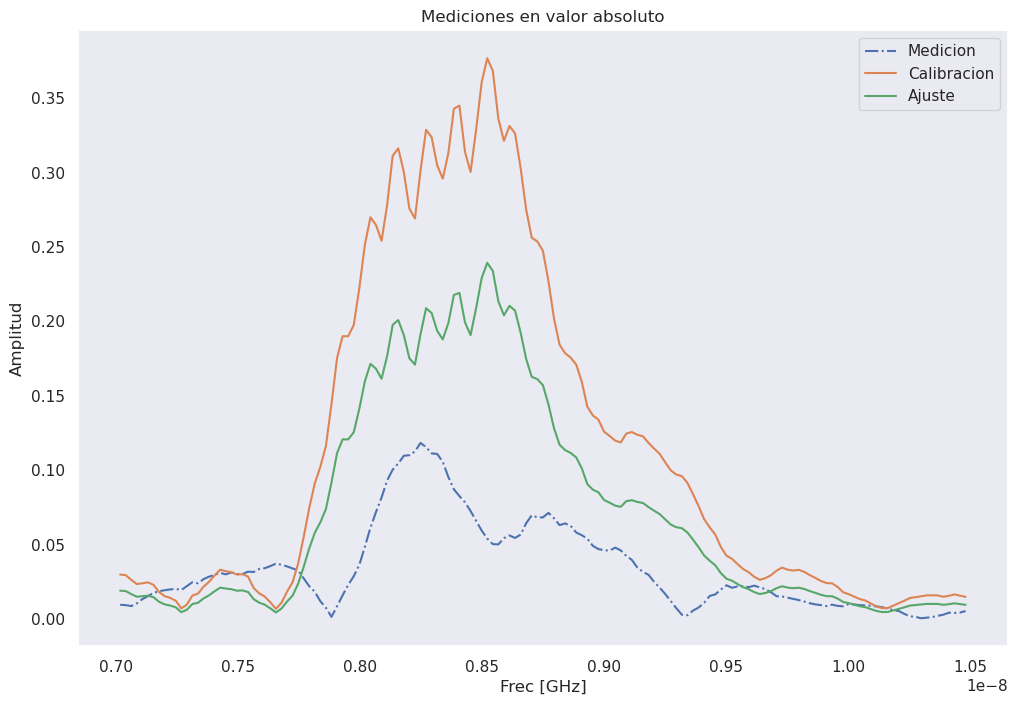

In [548]:
print('-------------------')
print('Incidencia en un dielectrico con 2 capas con rugosidad')
print('-------------------')
print()
print('Datos:')
print('Dia de calibracion:', dia_cal)
print('Dia de target:', dia_tar)
print('Altura:', altura)
name = 'rug-C'+X+'-T'+Y+'-A'+altura
print()
t0 = time.time()


print('-------------------')
print('Corro bayes')
print('-------------------')
# nro de muestras que va a utilizar el método
muestras = 5000
noise_level = 2.5e-2
# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))
print('Ruido : ',noise_level)
print('Muestras : ',muestras)
print()


# inferencia bayesiana
traza_sim_2layers = modelo(Star,muestras,sigmas,NLayers,True)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')


#Ploteo
print('Graficando para dos dieléctricos + rugosidad (esto puede demorar...)')
print()

ep1_r_mean = round(np.mean(traza_sim_2layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_2layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_2layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_2layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_2layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_2layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_2layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_2layers['ep2_i']),3)

d_mean = round(np.mean(traza_sim_2layers['d']),3)
d_std = round(np.std(traza_sim_2layers['d']),3)

s1_mean = round(np.mean(traza_sim_2layers['s0']),5)
s1_std = round(np.std(traza_sim_2layers['s0']),6)

s2_mean = round(np.mean(traza_sim_2layers['s1']),5)
s2_std = round(np.std(traza_sim_2layers['s1']),6)



plotear = np.stack((traza_sim_2layers['ep1_r'], traza_sim_2layers['ep1_i'], traza_sim_2layers['ep2_r'], 
                    traza_sim_2layers['ep2_i'], traza_sim_2layers['d'],traza_sim_2layers['s0'],traza_sim_2layers['s1'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep1_i','ep2_r','ep2_i','d','s0','s1'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
# g.map_lower(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
g.savefig('outputs/2capas/bayes-'+name+'.png')


# g.axes[0,0].axvline(np.real(ep1_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[1,1].axvline(np.imag(ep1_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[2,2].axvline(np.real(ep2_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[3,3].axvline(np.imag(ep2_s), color='r', linestyle='solid', linewidth=0.5)
# g.axes[4,4].axvline(d_s, color='r', linestyle='solid', linewidth=0.5)

# g.axes[1,0].scatter(np.real(ep1_s), np.imag(ep1_s), marker="+", c='r', s=200)
# g.axes[2,0].scatter(np.real(ep1_s), np.real(ep2_s), marker="+", c='r', s=200)
# g.axes[3,0].scatter(np.real(ep1_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,0].scatter(np.real(ep1_s), d_s, marker="+", c='r', s=200)

# g.axes[2,1].scatter(np.imag(ep1_s), np.real(ep2_s), marker="+", c='r', s=200)
# g.axes[3,1].scatter(np.imag(ep1_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,1].scatter(np.imag(ep1_s), d_s, marker="+", c='r', s=200)

# g.axes[3,2].scatter(np.real(ep2_s), np.imag(ep2_s), marker="+", c='r', s=200)
# g.axes[4,2].scatter(np.real(ep2_s), d_s, marker="+", c='r', s=200)

# g.axes[4,3].scatter(np.imag(ep2_s), d_s, marker="+", c='r', s=200)


print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std))
print()
print('input d: ', d_obs)
print('output d: ', str(d_mean)+" +/- "+str(d_std))
print()
print('input s1: ---')
print('output s1: ', str(s1_mean)+" +/- "+str(s1_std))
print()
print('input s2: ---')
print('output s2: ', str(s2_mean)+" +/- "+str(s2_std))
print()

t3 = time.time()
print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()

EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
Dist = d_mean
S1_opt = s1_mean
S2_opt = s2_mean

S_fit = Scal*R_pinel_2L(EP1,EP2,Dist,S1_opt,S2_opt,f_pos) # señal 'medida'

plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.title('Mediciones en valor absoluto')
plt.legend(loc="best")
plt.savefig('outputs/2capas/fig-'+name+'.png')
#----------------------------------------------

with open('outputs/2capas/'+name+'.txt', 'w') as f:
    print('-------------------', file=f)
    print('Incidencia en un dielectrico con 2 capas sin rugosidad', file=f)
    print('-------------------', file=f)
    print('', file=f)
    print('Datos:', file=f)
    print('Dia de calibracion:', dia_cal, file=f)
    print('Dia de target:', dia_tar, file=f)
    print('Altura:', altura, file=f)
    print('', file=f)
    print('', file=f)

    print('-------------------', file=f)
    print('Corro bayes', file=f)
    print('-------------------', file=f)
    print('Ruido : ',noise_level, file=f)
    print('Muestras : ',muestras, file=f)
    print('', file=f)
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
    print('', file=f)

    print('Graficando con un solo dielectrico ...', file=f)
    print('input ep1_r: ', np.real(ep1_obs), file=f)
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
    print('', file=f)
    print('input ep1_i: ', round(np.imag(ep1_obs)),3, file=f)
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
    print('', file=f)
    print('input ep2_r: ', np.real(ep2_obs), file=f)
    print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std), file=f)
    print('', file=f)
    print('input ep2_i: ', np.imag(ep2_obs), file=f)
    print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std), file=f)
    print('', file=f)
    print('input d: ', d_obs, file=f)
    print('output d: ', str(d_mean)+" +/- "+str(d_std), file=f)
    print('', file=f)
    print('input s1: ---', file=f)
    print('output s1: ', str(s1_mean)+" +/- "+str(s1_std), file=f)
    print('', file=f)
    print('input s2: ---', file=f)
    print('output s2: ', str(s2_mean)+" +/- "+str(s2_std), file=f)
    print('', file=f)
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('', file=f)
f.close()

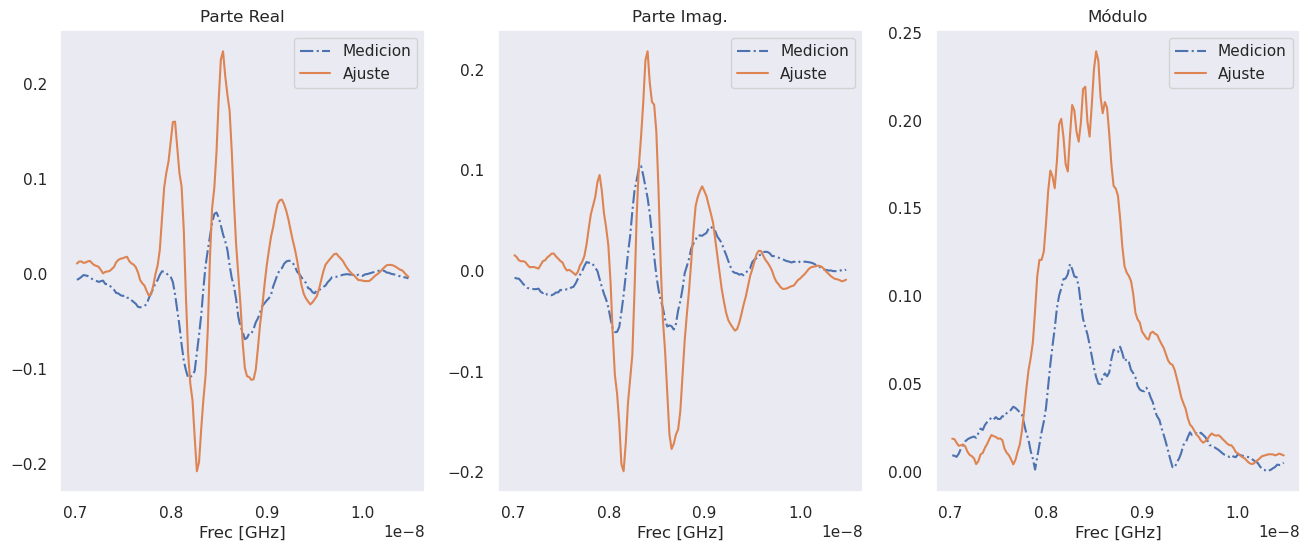

In [549]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(f_pos/1e9,np.real(Star),'-.',label="Medicion")
ax[0].plot(f_pos/1e9,np.real(S_fit),label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(f_pos/1e9,np.imag(Star),'-.',label="Medicion")
ax[1].plot(f_pos/1e9,np.imag(S_fit),label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
ax[2].plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()

# - Tres dieléctricos

In [550]:
NLayers = 3

if Y == '0':
    # mayo
    d1_obs = 6e-2
    d2_obs = 12e-2
    
    
elif Y == '1':
    # junio
    d1_obs =  9e-2
    d2_obs = 13e-2
    

elif Y == '2':
    # julio
    d1_obs =  2e-2
    d2_obs = 7e-2

else:
    # agosto
    d1_obs = 2e-2
    d2_obs = 9e-2



## Sin rugosidad

-------------------
Incidencia en un dielectrico con 3 capas sin rugosidad
-------------------

Datos:
Dia de calibracion: 07_15
Dia de target: 08_22
Altura: 1
-------------------
Corro bayes
-------------------
Ruido :  0.025
Muestras :  2500



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.027
Stage:   1 Beta: 0.076
Stage:   2 Beta: 0.173
Stage:   3 Beta: 0.386
Stage:   4 Beta: 0.858
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.027
Stage:   1 Beta: 0.073
Stage:   2 Beta: 0.170
Stage:   3 Beta: 0.383
Stage:   4 Beta: 0.860
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.027
Stage:   1 Beta: 0.076
Stage:   2 Beta: 0.177
Stage:   3 Beta: 0.395
Stage:   4 Beta: 0.881
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.027
Stage:   1 Beta: 0.074
Stage:   2 Beta: 0.171
Stage:   3 Beta: 0.391
Stage:   4 Beta: 0.861
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.027
Stage:   1 Beta: 0.075
Stage:   2 Beta: 0.176
Stage:   3 Beta: 0.395
Stage:   4 Beta: 0.868
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.027
Stage:   1 Beta: 0.075
Stage:   2 Beta: 0.174
Stage:   3 Beta: 0.389
Stage:   4 Beta: 0.878
Stage:   5 Beta: 1.000


Tiempo insumido - Inf. Bayesiana: 90.81 seg (1.51 min)
Graficando para tres dieléctricos (esto puede demorar...)


input ep1_r:  7.6
output ep1_r:  19.005 +/- 1.733

input ep1_i:  4.36
output ep1_i:  4.003 +/- 1.158

input ep2_r:  7.54
output ep2_r:  20.844 +/- 4.146

input ep2_i:  3.94
output ep2_i:  6.014 +/- 1.154

input ep3_r:  error
output ep3_r:  23.873 +/- 0.071

input ep3_i:  
output ep3_i:  4.247 +/- 0.233

input d1:  0.02
output d1:  0.025 +/- 0.009

input d2:  0.09
output d2:  0.105 +/- 0.026

Tiempo insumido - Graficos: 3.81 seg (0.06 min)

Tiempo insumido - TOTAL: 94.62 seg (1.58 min)





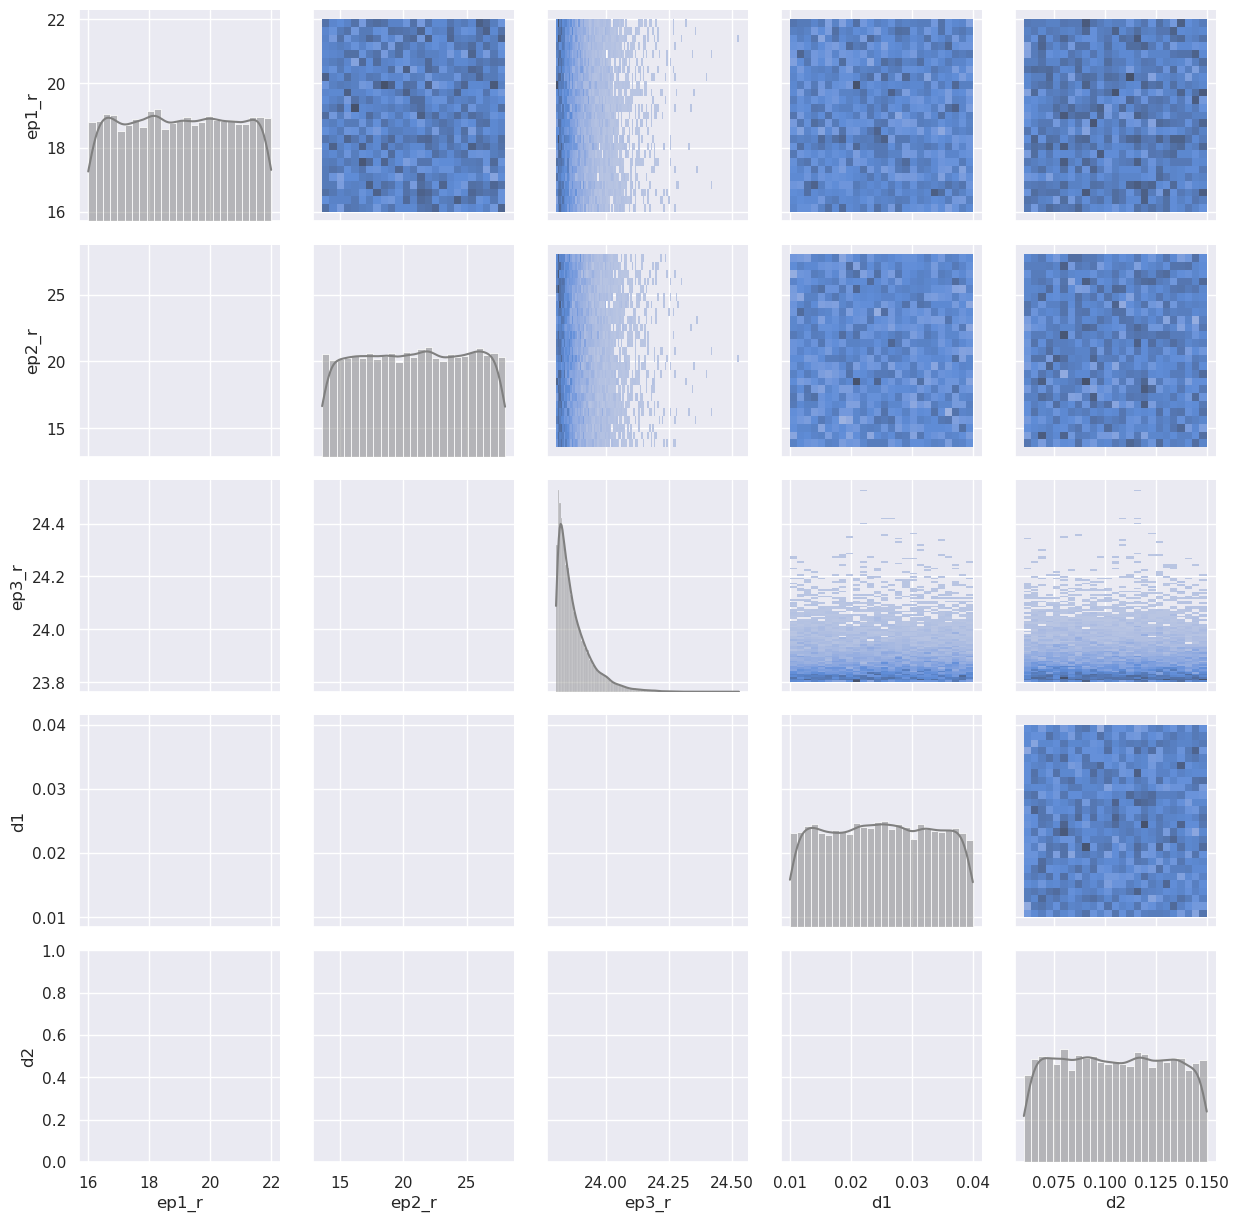

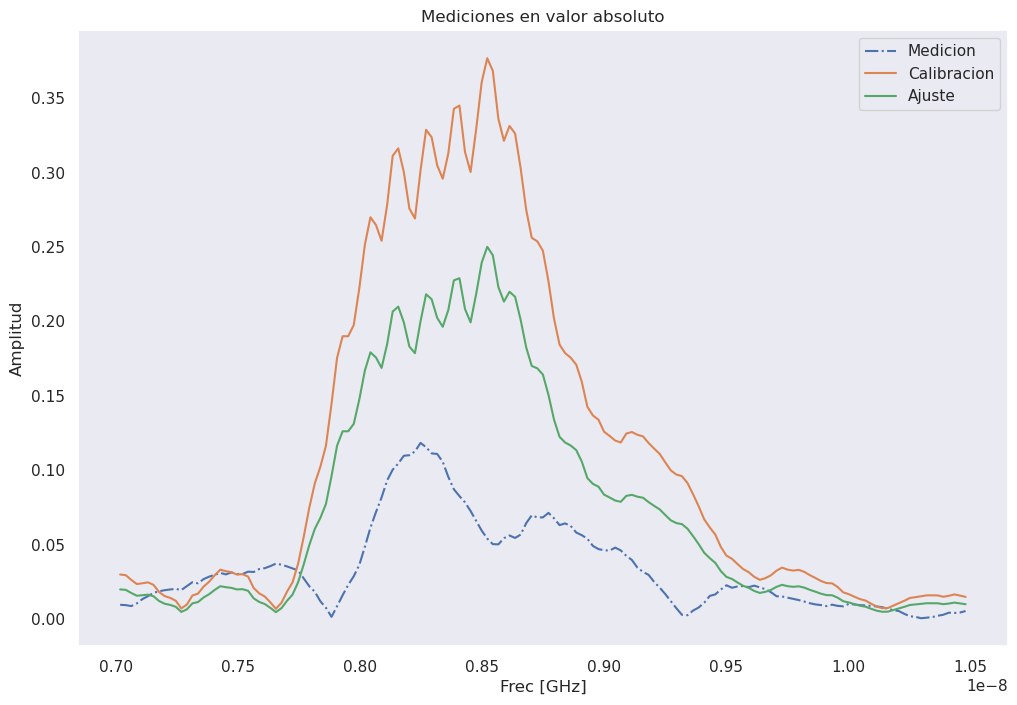

In [551]:
print('-------------------')
print('Incidencia en un dielectrico con 3 capas sin rugosidad')
print('-------------------')
print()
print('Datos:')
print('Dia de calibracion:', dia_cal)
print('Dia de target:', dia_tar)
print('Altura:', altura)
name = 'lisa-C'+X+'-T'+Y+'-A'+altura
t0 = time.time()

print('-------------------')
print('Corro bayes')
print('-------------------')
# nro de muestras que va a utilizar el método
muestras = 2500
noise_level = 2.5e-2
# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))

print('Ruido : ',noise_level)
print('Muestras : ',muestras)
print()


# inferencia bayesiana
traza_sim_3layers = modelo(Star,muestras,sigmas,NLayers,rug=False)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

#Ploteo
t2 = time.time()
print('Graficando para tres dieléctricos (esto puede demorar...)')
print()

ep1_r_mean = round(np.mean(traza_sim_3layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_3layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_3layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_3layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_3layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_3layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_3layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_3layers['ep2_i']),3)

ep3_r_mean = round(np.mean(traza_sim_3layers['ep3_r']),3)
ep3_r_std = round(np.std(traza_sim_3layers['ep3_r']),3)

ep3_i_mean = round(np.mean(traza_sim_3layers['ep3_i']),3)
ep3_i_std = round(np.std(traza_sim_3layers['ep3_i']),3)

d1_mean = round(np.mean(traza_sim_3layers['d1']),3)
d1_std = round(np.std(traza_sim_3layers['d1']),3)

d2_mean = round(np.mean(traza_sim_3layers['d2']),3)
d2_std = round(np.std(traza_sim_3layers['d2']),3)

plotear = np.stack((traza_sim_3layers['ep1_r'], traza_sim_3layers['ep2_r'], traza_sim_3layers['ep3_r'], 
                    traza_sim_3layers['d1'], traza_sim_3layers['d2'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep2_r','ep3_r','d1','d2'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
#g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
g.savefig('outputs/3capas/bayes-'+name+'.png')

print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std))
print()
print('input ep3_r: ', np.real(ep3_obs))
print('output ep3_r: ', str(ep3_r_mean)+" +/- "+str(ep3_r_std))
print()
print('input ep3_i: ', np.imag(ep3_obs))
print('output ep3_i: ', str(ep3_i_mean)+" +/- "+str(ep3_i_std))
print()
print('input d1: ', d1_obs)
print('output d1: ', str(d1_mean)+" +/- "+str(d1_std))
print()
print('input d2: ', d2_obs)
print('output d2: ', str(d2_mean)+" +/- "+str(d2_std))
print()

t3 = time.time()
print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()

#---------------------------------------------
EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
EP3 = ep3_r_mean + 1j*ep3_i_mean
D1 = d1_mean
D2 = d2_mean

S_fit = Scal*R_ep1_ep2_ep3(EP1,EP2,EP3,D1,D2,f_pos)

plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.title('Mediciones en valor absoluto')
plt.legend(loc="best")
plt.savefig('outputs/3capas/fig-'+name+'.png')
#----------------------------------------------

with open('outputs/3capas/'+name+'.txt', 'w') as f:
    print('-------------------', file=f)
    print('Incidencia en un dielectrico con 2 capas sin rugosidad', file=f)
    print('-------------------', file=f)
    print('', file=f)
    print('Datos:', file=f)
    print('Dia de calibracion:', dia_cal, file=f)
    print('Dia de target:', dia_tar, file=f)
    print('Altura:', altura, file=f)
    print('', file=f)
    print('', file=f)
    print('-------------------', file=f)
    print('Corro bayes', file=f)
    print('-------------------', file=f)
    print('Ruido : ',noise_level, file=f)
    print('Muestras : ',muestras, file=f)
    print('', file=f)
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('Graficando con un solo dielectrico ...', file=f)
    print('input ep1_r: ', np.real(ep1_obs), file=f)
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
    print('', file=f)
    print('input ep1_i: ', round(np.imag(ep1_obs)),3, file=f)
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
    print('', file=f)
    print('input ep2_r: ', np.real(ep2_obs), file=f)
    print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std), file=f)
    print('', file=f)
    print('input ep2_i: ', np.imag(ep2_obs), file=f)
    print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std), file=f)
    print('', file=f)
    print('input ep3_r: ', np.real(ep3_obs), file=f)
    print('output ep3_r: ', str(ep3_r_mean)+" +/- "+str(ep3_r_std), file=f)
    print('', file=f)
    print('input ep3_i: ', np.imag(ep3_obs), file=f)
    print('output ep3_i: ', str(ep3_i_mean)+" +/- "+str(ep3_i_std), file=f)
    print('', file=f)
    print('input d1: ', d1_obs, file=f)
    print('output d1: ', str(d1_mean)+" +/- "+str(d1_std), file=f)
    print('', file=f)
    print('input d2: ', d2_obs, file=f)
    print('output d2: ', str(d2_mean)+" +/- "+str(d2_std), file=f)
    print('', file=f)
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('', file=f)
f.close()

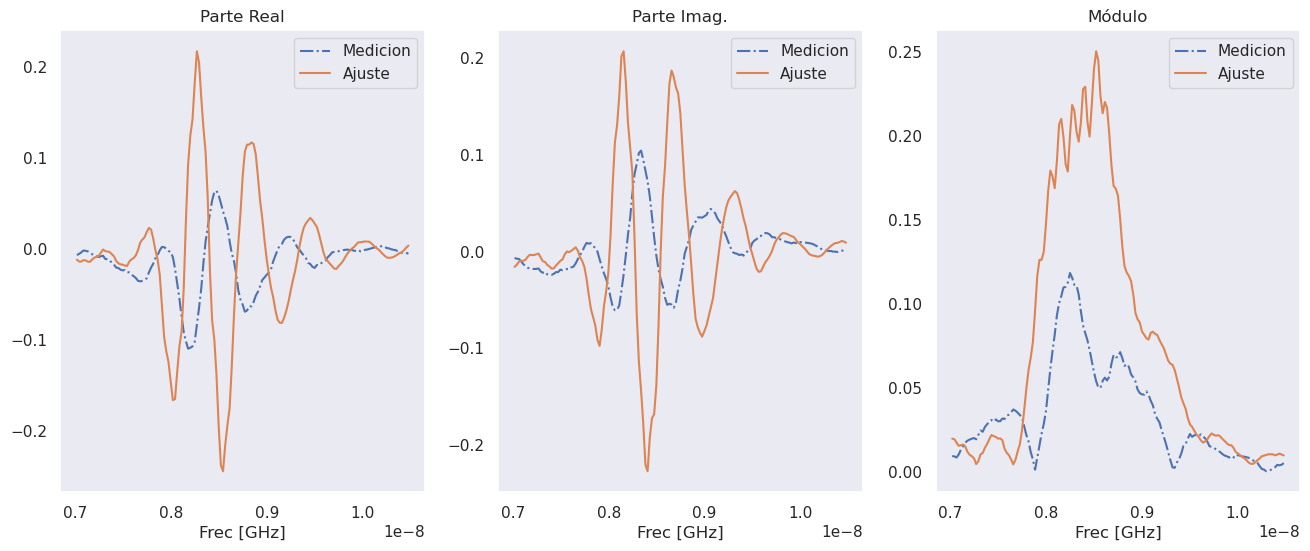

In [552]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(f_pos/1e9,np.real(Star),'-.',label="Medicion")
ax[0].plot(f_pos/1e9,np.real(S_fit),label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(f_pos/1e9,np.imag(Star),'-.',label="Medicion")
ax[1].plot(f_pos/1e9,np.imag(S_fit),label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
ax[2].plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()

## Con rugosidad

In [553]:
%run Bayes2.ipynb

-------------------
Incidencia en un dielectrico con 3 capas y rugosidad
-------------------

Datos:
Dia de calibracion: 07_15
Dia de target: 08_22
Altura: 1

-------------------
Corro bayes
-------------------
Ruido :  0.025
Muestras :  2500



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.021
Stage:   2 Beta: 0.049
Stage:   3 Beta: 0.103
Stage:   4 Beta: 0.198
Stage:   5 Beta: 0.363
Stage:   6 Beta: 0.630
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.021
Stage:   2 Beta: 0.050
Stage:   3 Beta: 0.104
Stage:   4 Beta: 0.201
Stage:   5 Beta: 0.368
Stage:   6 Beta: 0.630
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.021
Stage:   2 Beta: 0.049
Stage:   3 Beta: 0.102
Stage:   4 Beta: 0.195
Stage:   5 Beta: 0.359
Stage:   6 Beta: 0.622
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.020
Stage:   2 Beta: 0.049
Stage:   3 Beta: 0.101
Stage:   4 Beta: 0.197
Stage:   5 Beta: 0.358
Stage:   6 Beta: 0.614
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.007
Stage:   1 Beta: 0.020
Stage:   2 Beta: 0.049
Stage:   3 Beta: 0.101
Stage:   4 Beta: 0.192
Stage:   5 Beta: 0.352
Stage:   6 Beta: 0.604
Stage:   7 Beta: 0.999
Stage:   8 Beta: 1.000
S

Tiempo insumido - Inf. Bayesiana: 145.39 seg (2.42 min)
Graficando para dos dieléctricos + rugosidad (esto puede demorar...)


input ep1_r:  7.6
output ep1_r:  17.444 +/- 0.483

input ep1_i:  4.36
output ep1_i:  5.598 +/- 0.466

input ep2_r:  7.54
output ep2_r:  19.632 +/- 3.617

input ep2_i:  3.94
output ep2_i:  5.232 +/- 1.47

input ep3_r:  error
output ep3_r:  22.033 +/- 0.031

input ep3_i:  
output ep3_i:  3.118 +/- 0.11

input d1:  0.02
output d1:  0.055 +/- 0.026

input d2:  0.09
output d2:  0.175 +/- 0.043

input s0: ---
output s0:  0.00101 +/- 0.000571

input s1: ---
output s1:  0.00101 +/- 0.000576

input s2: ---
output s2:  0.001 +/- 0.000575

Tiempo insumido - Graficos: 6.88 seg (0.11 min)

Tiempo insumido - TOTAL: 152.27 seg (2.54 min)





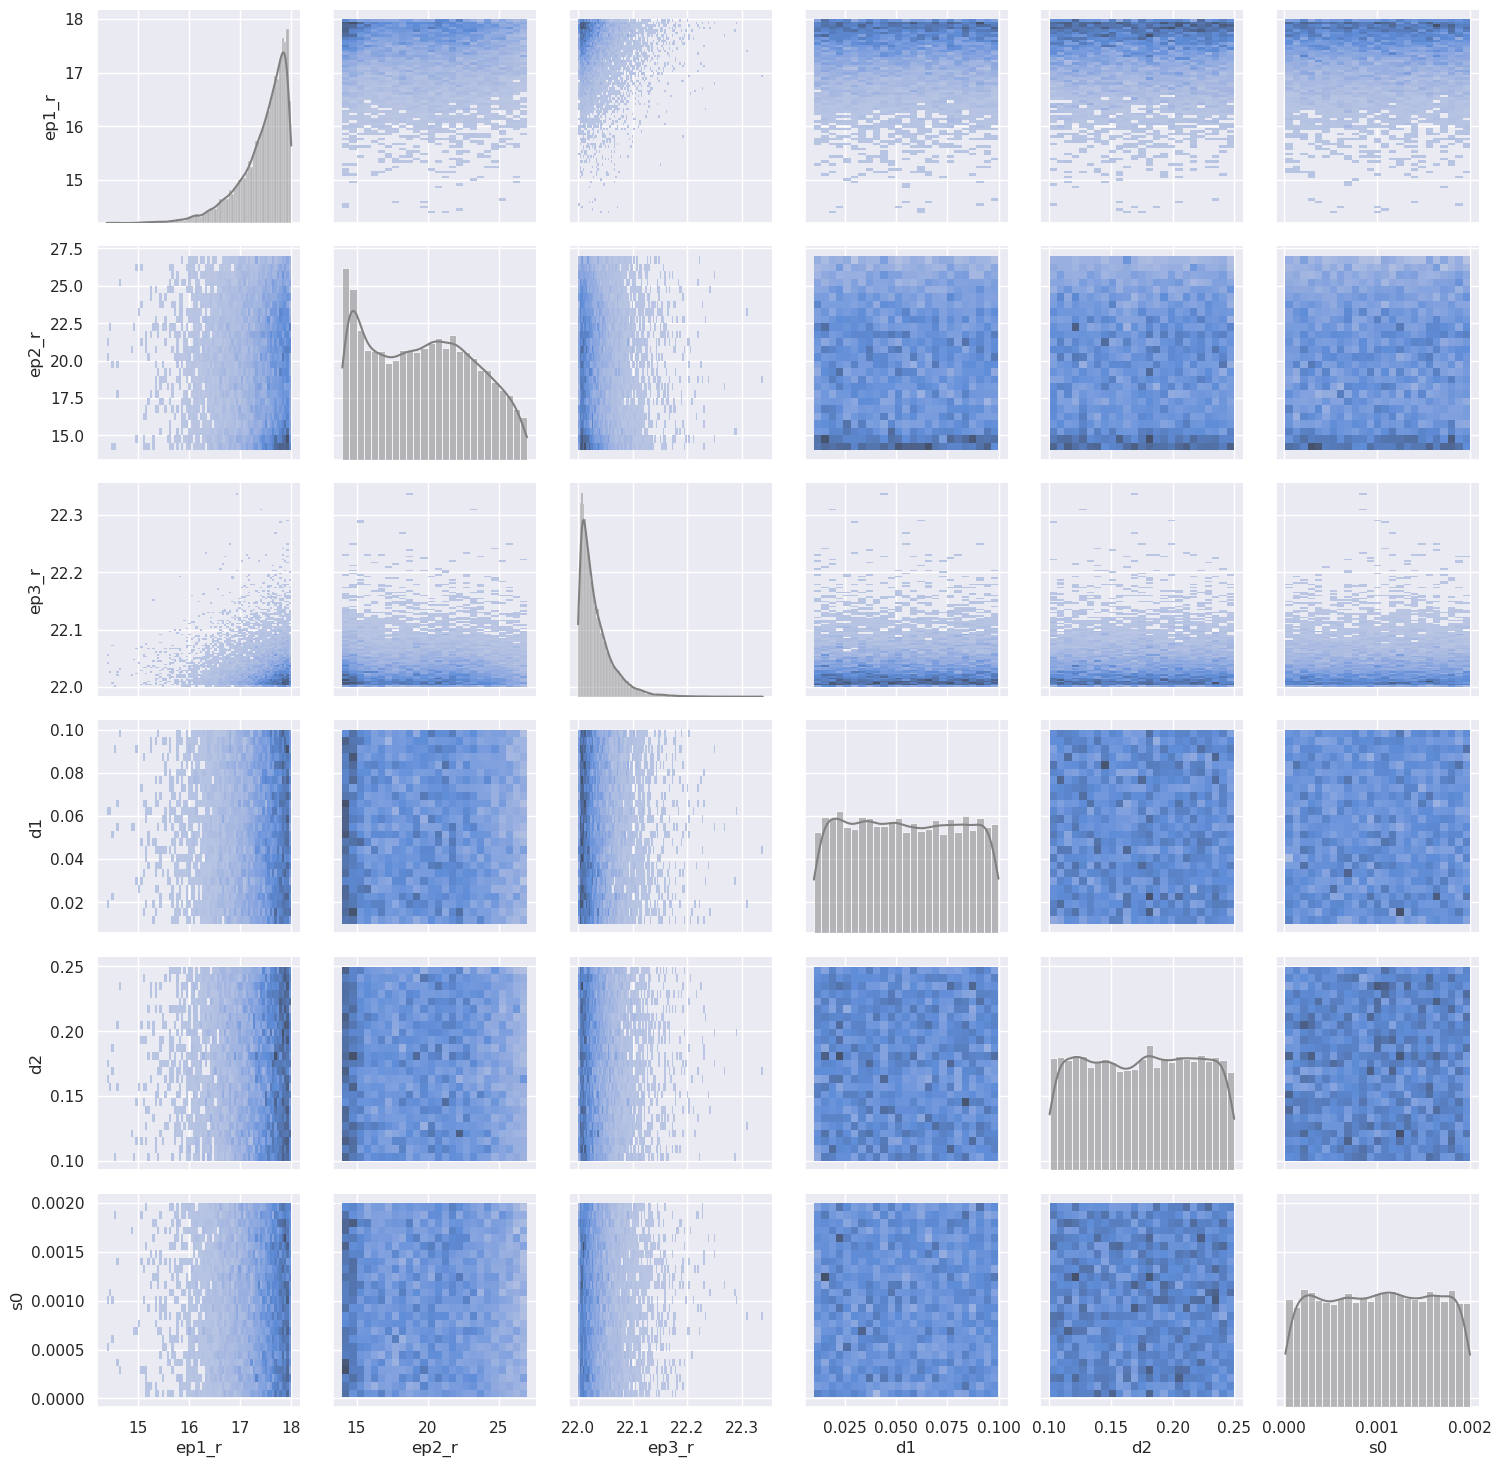

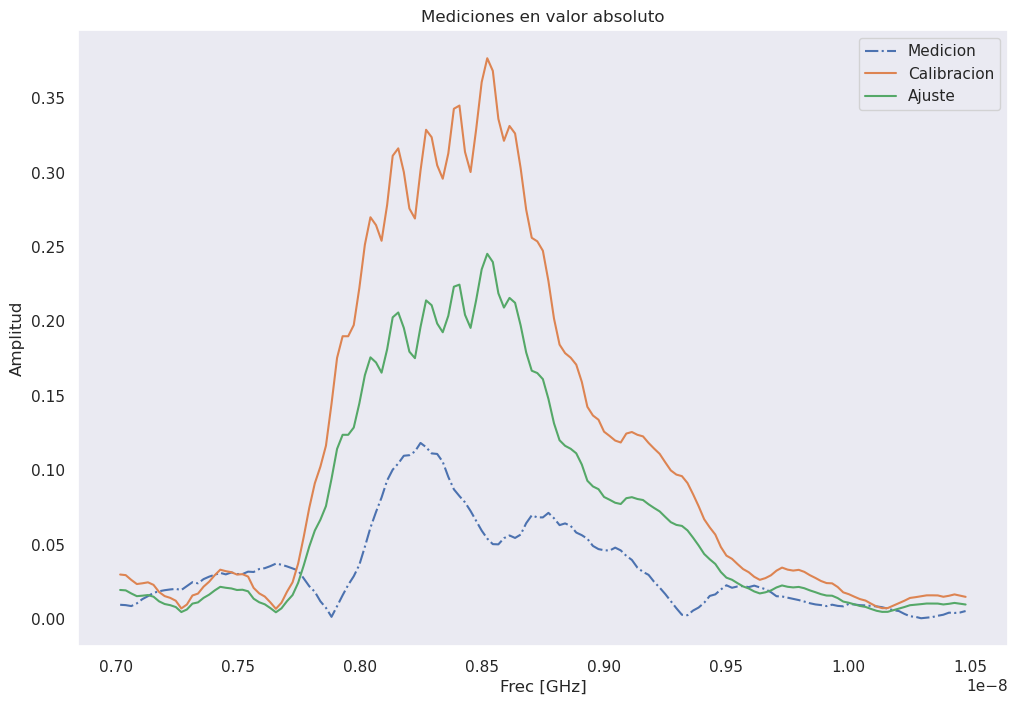

In [554]:
print('-------------------')
print('Incidencia en un dielectrico con 3 capas y rugosidad')
print('-------------------')
print()
print('Datos:')
print('Dia de calibracion:', dia_cal)
print('Dia de target:', dia_tar)
print('Altura:', altura)
name = 'rug-C'+X+'-T'+Y+'-A'+altura
print()
t0 = time.time()

print('-------------------')
print('Corro bayes')
print('-------------------')
# nro de muestras que va a utilizar el método
muestras = 2500
noise_level = 2.5e-2
# error de la medición
sigmas = noise_level*np.ones((2,len(Star)))

print('Ruido : ',noise_level)
print('Muestras : ',muestras)
print()


# inferencia bayesiana
traza_sim_3layers = modelo(Star,muestras,sigmas,NLayers,True)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')



#Ploteo
t2 = time.time()
print('Graficando para dos dieléctricos + rugosidad (esto puede demorar...)')
print()

ep1_r_mean = round(np.mean(traza_sim_3layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_3layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_3layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_3layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_3layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_3layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_3layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_3layers['ep2_i']),3)

ep3_r_mean = round(np.mean(traza_sim_3layers['ep3_r']),3)
ep3_r_std = round(np.std(traza_sim_3layers['ep3_r']),3)

ep3_i_mean = round(np.mean(traza_sim_3layers['ep3_i']),3)
ep3_i_std = round(np.std(traza_sim_3layers['ep3_i']),3)

d1_mean = round(np.mean(traza_sim_3layers['d1']),3)
d1_std = round(np.std(traza_sim_3layers['d1']),3)

d2_mean = round(np.mean(traza_sim_3layers['d2']),3)
d2_std = round(np.std(traza_sim_3layers['d2']),3)

s0_mean = round(np.mean(traza_sim_3layers['s0']),5)
s0_std = round(np.std(traza_sim_3layers['s0']),6)

s1_mean = round(np.mean(traza_sim_3layers['s1']),5)
s1_std = round(np.std(traza_sim_3layers['s1']),6)

s2_mean = round(np.mean(traza_sim_3layers['s2']),5)
s2_std = round(np.std(traza_sim_3layers['s2']),6)

plotear = np.stack((traza_sim_3layers['ep1_r'], traza_sim_3layers['ep2_r'], traza_sim_3layers['ep3_r'],
                    traza_sim_3layers['d1'],traza_sim_3layers['d2'],traza_sim_3layers['s0'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep2_r','ep3_r','d1','d2','s0'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
g.map_lower(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
g.savefig('outputs/3capas/bayes-'+name+'.png')

print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std))
print()
print('input ep3_r: ', np.real(ep3_obs))
print('output ep3_r: ', str(ep3_r_mean)+" +/- "+str(ep3_r_std))
print()
print('input ep3_i: ', np.imag(ep3_obs))
print('output ep3_i: ', str(ep3_i_mean)+" +/- "+str(ep3_i_std))
print()
print('input d1: ', d1_obs)
print('output d1: ', str(d1_mean)+" +/- "+str(d1_std))
print()
print('input d2: ', d2_obs)
print('output d2: ', str(d2_mean)+" +/- "+str(d2_std))
print()
print('input s0: ---')
print('output s0: ', str(s0_mean)+" +/- "+str(s0_std))
print()
print('input s1: ---')
print('output s1: ', str(s1_mean)+" +/- "+str(s1_std))
print()
print('input s2: ---')
print('output s2: ', str(s2_mean)+" +/- "+str(s2_std))
print()


t3 = time.time()
print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()


#---------------------------------------------
EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
EP3 = ep3_r_mean + 1j*ep3_i_mean

D1 = d1_mean
D2 = d2_mean
S0_opt = s0_mean
S1_opt = s1_mean
S2_opt = s2_mean

S_fit = Scal*R_pinel_3L(EP1,EP2,EP3,D1,D2,S0_opt,S1_opt,S2_opt,f_pos) # señal 'medida'


plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.title('Mediciones en valor absoluto')
plt.legend(loc="best")
plt.savefig('outputs/3capas/fig-'+name+'.png')
#----------------------------------------------


with open('outputs/3capas/'+name+'.txt', 'w') as f:
    print('-------------------', file=f)
    print('Incidencia en un dielectrico con 2 capas sin rugosidad', file=f)
    print('-------------------', file=f)
    print('', file=f)
    print('Datos:', file=f)
    print('Dia de calibracion:', dia_cal, file=f)
    print('Dia de target:', dia_tar, file=f)
    print('Altura:', altura, file=f)
    print('', file=f)
    print('', file=f)

    print('-------------------', file=f)
    print('Corro bayes', file=f)
    print('-------------------', file=f)
    print('Ruido : ',noise_level, file=f)
    print('Muestras : ',muestras, file=f)
    print('', file=f)
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
    print('', file=f)

    print('Graficando con un solo dielectrico ...', file=f)
    print('input ep1_r: ', np.real(ep1_obs), file=f)
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
    print('', file=f)
    print('input ep1_i: ', round(np.imag(ep1_obs)),3, file=f)
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
    print('', file=f)
    print('input ep2_r: ', np.real(ep2_obs), file=f)
    print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std), file=f)
    print('', file=f)
    print('input ep2_i: ', np.imag(ep2_obs), file=f)
    print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std), file=f)
    print('', file=f)
    print('input ep3_i: ', np.imag(ep3_obs), file=f)
    print('output ep3_i: ', str(ep3_i_mean)+" +/- "+str(ep3_i_std), file=f)
    print('', file=f)
    print('input d1: ', d1_obs, file=f)
    print('output d1: ', str(d1_mean)+" +/- "+str(d1_std), file=f)
    print('', file=f)
    print('input d2: ', d2_obs, file=f)
    print('output d2: ', str(d2_mean)+" +/- "+str(d2_std), file=f)
    print('', file=f)
    print('input s0: ---', file=f)
    print('output s0: ', str(s0_mean)+" +/- "+str(s0_std), file=f)
    print('', file=f)
    print('input s1: ---', file=f)
    print('output s1: ', str(s1_mean)+" +/- "+str(s1_std), file=f)
    print('', file=f)
    print('input s2: ---', file=f)
    print('output s2: ', str(s2_mean)+" +/- "+str(s2_std), file=f)
    print('', file=f)
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('', file=f)
f.close()